# Домашнее задание: анализ A/A/B теста

Есть A/A/B-тестирования от одного известного маркетплейса.

> sample_a, sample_c — АА-группы, sample_b — отдельная группа.

В каждом датасете есть три типа действий пользователей: 0 — клик, 1 — просмотр и 2 — покупка (пользователь просматривает выдачу товаров, кликает на понравившийся товар и совершает покупку).

Маркетплейс ориентируется на следующие метрики:

* ctr (отношение кликов к просмотрам товаров);
* purchase rate (отношение покупок к просмотрам товаров);
* gmv (оборот, сумма произведений количества покупок на стоимость покупки), где считаем 1 сессию за 1 точку (1 сессия на 1 пользователя).

### Задача — понять, нет ли проблемы с разъезжанием сплитов и улучшает ли алгоритм B работу маркетплейса.

In [100]:
import pandas as pd
import numpy as np

from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.proportion import proportions_ztest

In [16]:
sample_a = pd.read_csv('data/sample_a.zip')
sample_b = pd.read_csv('data/sample_b.zip')
sample_c = pd.read_csv('data/sample_c.zip')
prices = pd.read_csv('data/item_prices.zip')

def show_data(df, title):
    print(title)
    display(df.head(5))
    display(df.info())

show_data(sample_a, "Sample A:")
show_data(sample_b, "Sample B:")
show_data(sample_c, "Sample C:")
show_data(prices, "Item prices:")


Sample A:


,user_id,item_id,action_id
0,84636,360,1
1,21217,9635,1
2,13445,8590,1
3,38450,5585,1
4,14160,2383,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1188912 entries, 0 to 1188911
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1188912 non-null  int64
 1   item_id    1188912 non-null  int64
 2   action_id  1188912 non-null  int64
dtypes: int64(3)
memory usage: 27.2 MB


None

Sample B:


,user_id,item_id,action_id
0,118375,4105,1
1,107569,8204,1
2,175990,880,1
3,160582,9568,0
4,123400,4000,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1198438 entries, 0 to 1198437
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1198438 non-null  int64
 1   item_id    1198438 non-null  int64
 2   action_id  1198438 non-null  int64
dtypes: int64(3)
memory usage: 27.4 MB


None

Sample C:


,user_id,item_id,action_id
0,274623,2863,1
1,265472,343,1
2,242779,6009,0
3,275009,2184,1
4,268104,3134,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205510 entries, 0 to 1205509
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1205510 non-null  int64
 1   item_id    1205510 non-null  int64
 2   action_id  1205510 non-null  int64
dtypes: int64(3)
memory usage: 27.6 MB


None

Item prices:


,item_id,item_price
0,338,1501
1,74,647
2,7696,825
3,866,875
4,5876,804


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   item_id     1000 non-null   int64
 1   item_price  1000 non-null   int64
dtypes: int64(2)
memory usage: 15.8 KB


None

### Оставляем достоверные сессии

Следующие сессии являются достоверными (валидными):

1. Есть только просмотр товара

2. Есть просмотр и клик

3. Есть просмотр, клик и покупка

Все остальные сессии исключим.

In [76]:
def filter_valid_sessions(df):

    # Группируем по user_id и item_id, собираем все действия в список
    grouped = df.groupby(['user_id', 'item_id'])['action_id'].agg(list).reset_index()

    # Проверяем валидность каждой группы
    def is_valid(actions):
        if 1 not in actions:  # Если нет просмотра
            return False  # Исключаем
        if 2 in actions and 0 not in actions:  # Есть покупка, но нет клика
            return False  # Исключаем
        return True  # Все остальные случаи корректны

    # Оставляем только валидные группы
    valid_groups = grouped[grouped['action_id'].apply(is_valid)]

    # Соединяем с исходными данными, чтобы оставить только валидные строки
    valid_df = df.merge(valid_groups[['user_id', 'item_id']], on=['user_id', 'item_id'], how='inner')

    return valid_df

print("sample_a:", sample_a.shape)
sample_a_cleaned = filter_valid_sessions(sample_a)
print("sample_a_cleaned:", sample_a_cleaned.shape)
print(f" - исключено строк: {sample_a.shape[0] - sample_a_cleaned.shape[0]}")

print("sample_b:", sample_b.shape)
sample_b_cleaned = filter_valid_sessions(sample_b)
print("sample_b_cleaned:", sample_b_cleaned.shape)
print(f" - исключено строк: {sample_b.shape[0] - sample_b_cleaned.shape[0]}")

print("sample_c:", sample_c.shape)
sample_c_cleaned = filter_valid_sessions(sample_c)
print("sample_c_cleaned:", sample_c_cleaned.shape)
print(f" - исключено строк: {sample_c.shape[0] - sample_c_cleaned.shape[0]}")


sample_a: (1188912, 3)
sample_a_cleaned: (1112820, 3)
 - исключено строк: 76092
sample_b: (1198438, 3)
sample_b_cleaned: (1038568, 3)
 - исключено строк: 159870
sample_c: (1205510, 3)
sample_c_cleaned: (1115490, 3)
 - исключено строк: 90020


### Расчитам метрики по датасетам 

In [77]:
def calculate_metrics_with_gmv(df, prices):
    """
    Рассчитывает CTR, Purchase Rate и GMV для группы данных с учетом цен товаров.

    Параметры:
    - df: DataFrame с действиями пользователей.
    - prices: DataFrame с ценами товаров (item_id и item_price).

    Возвращает:
    - Словарь с рассчитанными метриками.
    """
    # Считаем количество просмотров, кликов и покупок
    views = len(df[df['action_id'] == 1])
    clicks = len(df[df['action_id'] == 0])

    # Отбираем все покупки и соединяем с ценами
    purchases = df[df['action_id'] == 2].merge(
        prices, on='item_id', how='left'
    )

    # Рассчитываем GMV как сумму стоимостей покупок
    gmv = purchases['item_price'].sum()

    # Рассчитываем метрики CTR и Purchase Rate
    ctr = clicks / views if views > 0 else 0
    purchase_rate = len(purchases) / views if views > 0 else 0

    return {
        'CTR': ctr,
        'Purchase Rate': purchase_rate,
        'GMV': gmv
    }

# Пример использования для каждой группы
metrics_a = calculate_metrics_with_gmv(sample_a_cleaned, prices)
metrics_b = calculate_metrics_with_gmv(sample_b_cleaned, prices)
metrics_c = calculate_metrics_with_gmv(sample_c_cleaned, prices)

print("Metrics for sample_a:", metrics_a)
print("Metrics for sample_b:", metrics_b)
print("Metrics for sample_c:", metrics_c)

Metrics for sample_a: {'CTR': 0.20833351586491494, 'Purchase Rate': 0.010858803790231786, 'GMV': 10681225}
Metrics for sample_b: {'CTR': 0.17468084471410894, 'Purchase Rate': 0.018229901997920125, 'GMV': 17013290}
Metrics for sample_c: {'CTR': 0.22045296949495194, 'Purchase Rate': 0.013848537564794058, 'GMV': 13330484}


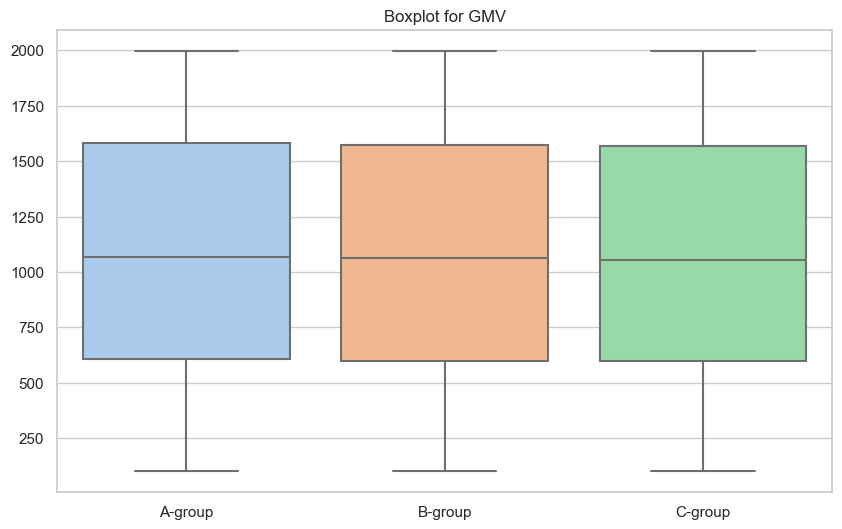

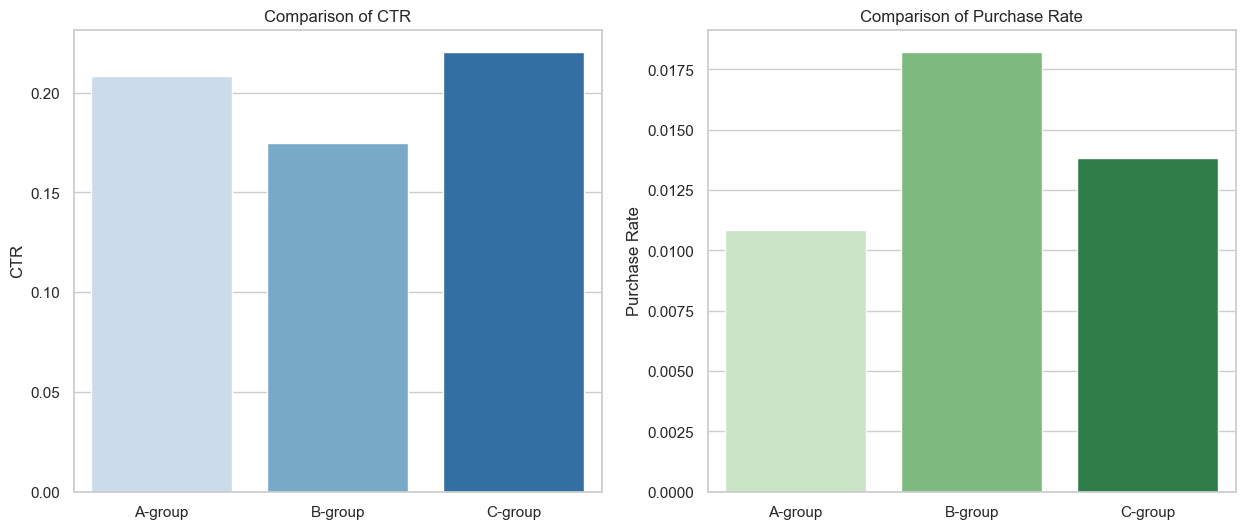

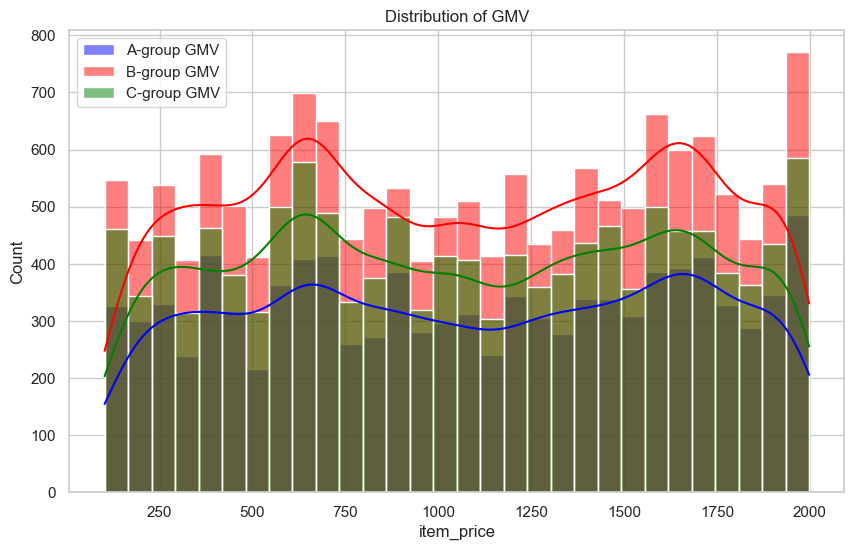

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
sns.set(style="whitegrid")

# Данные для визуализации
ctr_values = [metrics_a['CTR'], metrics_b['CTR'], metrics_c['CTR']]
purchase_rate_values = [
    metrics_a['Purchase Rate'], metrics_b['Purchase Rate'], metrics_c['Purchase Rate']
]

# Извлечение цен покупок для каждой группы
gmv_a = sample_a_cleaned[sample_a_cleaned['action_id'] == 2].merge(
    prices, on='item_id')['item_price']
gmv_b = sample_b_cleaned[sample_b_cleaned['action_id'] == 2].merge(
    prices, on='item_id')['item_price']
gmv_c = sample_c_cleaned[sample_c_cleaned['action_id'] == 2].merge(
    prices, on='item_id')['item_price']

# 1. Boxplot для GMV по всем группам
plt.figure(figsize=(10, 6))
sns.boxplot(data=[gmv_a, gmv_b, gmv_c], palette="pastel")
plt.xticks([0, 1, 2], ['A-group', 'B-group', 'C-group'])
plt.title('Boxplot for GMV')
plt.show()

# 2. Barplot для сравнения CTR и Purchase Rate
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Barplot для CTR
sns.barplot(x=['A-group', 'B-group', 'C-group'], y=ctr_values, ax=axes[0], palette="Blues")
axes[0].set_title('Comparison of CTR')
axes[0].set_ylabel('CTR')

# Barplot для Purchase Rate
sns.barplot(x=['A-group', 'B-group', 'C-group'], y=purchase_rate_values, ax=axes[1], palette="Greens")
axes[1].set_title('Comparison of Purchase Rate')
axes[1].set_ylabel('Purchase Rate')

plt.show()

# 3. Гистограммы для GMV по всем группам
plt.figure(figsize=(10, 6))
sns.histplot(gmv_a, kde=True, color='blue', label='A-group GMV', bins=30)
sns.histplot(gmv_b, kde=True, color='red', label='B-group GMV', bins=30)
sns.histplot(gmv_c, kde=True, color='green', label='C-group GMV', bins=30)
plt.title('Distribution of GMV')
plt.legend()
plt.show()


### Выводы

* по CTR (Click-Through Rate):
    * группа B (0.1747) показывает значительно более низкий CTR по сравнению с A-группами (0.2083 и 0.2205)
    * обе A-группы (sample_a и sample_c) имеют схожие CTR (~20-22%), что указывает на корректное разбиение между этими контрольными группами

* по Purchase Rate (Процент покупок)
    * в группе B наблюдается высокий процент покупок (1.82%) по сравнению с A-группами (1.09% и 1.38%)
    * такой результат может говорить о более целенаправленных кликах или об улучшении процесса покупки в группе B

* по GMV (Gross Merchandise Volume):
    * GMV в группе B (17 013 290) значительно выше по сравнению с обеими A-группами
    * этот результат подтверждает, что увеличение процента покупок в B-группе компенсирует снижение CTR и приводит к большему обороту
    * различие между GMV в группах A (sample_a и sample_c) также заметно, но не столь существенно, что подтверждает, что A-группы сопоставимы между собой

* по графиков плотности (KDE):
    * B-группа демонстрирует более высокую активность по всем интервалам цен. Это указывает на то, что:
        * либо пользователи в B-группе склонны делать больше покупок.
        * либо алгоритм, использованный для этой группы, более эффективно предлагает дорогие товары.
    * группы A и C имеют очень похожие распределения, что согласуется с тем, что эти группы были контрольными и должны показывать сходное поведение.

Для проверки равенства метрик между двумя A-группами (`sample_a` и `sample_c`) используем `t-тест` для независимых выборок (для непрерывной метрики GMV) и `z-тест` для пропорций (для сравнения долей, например CTR и Purchase Rate).

In [106]:
def z_test_proportions(success_a, total_a, success_c, total_c):
    """
    Выполняет z-тест пропорций.

    Параметры:
    success_a, success_c — количество успехов (например, кликов).
    total_a, total_c — общее количество испытаний (например, просмотров).

    Возвращает:
    z-статистику и p-значение.
    """
    count = np.array([success_a, success_c])
    nobs = np.array([total_a, total_c])

    stat, p_value = proportions_ztest(count, nobs)
    return stat, p_value


def t_test_means(sample_a, sample_c):
    """
    Выполняет t-тест для двух выборок.

    Параметры:
    sample_a, sample_c — данные двух выборок для сравнения.

    Возвращает:
    t-статистику и p-значение.
    """
    t_stat, p_value = stats.ttest_ind(sample_a, sample_c, equal_var=False)
    return t_stat, p_value


# Считаем фактическое количество кликов и просмотров для sample_a и sample_c
clicks_a = len(sample_a_cleaned[sample_a_cleaned['action_id'] == 0])
views_a = len(sample_a_cleaned[sample_a_cleaned['action_id'] == 1])

clicks_c = len(sample_c_cleaned[sample_c_cleaned['action_id'] == 0])
views_c = len(sample_c_cleaned[sample_c_cleaned['action_id'] == 1])

# Выполняем z-тест для сравнения CTR
z_ctr, p_ctr = z_test_proportions(
    success_a=clicks_a,
    total_a=views_a,
    success_c=clicks_c,
    total_c=views_c
)

# Считаем фактическое количество покупок для z-теста по Purchase Rate
purchases_a = len(sample_a_cleaned[sample_a_cleaned['action_id'] == 2])
purchases_c = len(sample_c_cleaned[sample_c_cleaned['action_id'] == 2])

# Выполняем z-тест для сравнения Purchase Rate
z_purchase_rate, p_purchase_rate = z_test_proportions(
    success_a=purchases_a,
    total_a=views_a,
    success_c=purchases_c,
    total_c=views_c
)

##################################################################
# Выполняем t-тест для GMV
##################################################################

# Извлечение цен покупок для каждой группы
gmv_a = sample_a_cleaned[sample_a_cleaned['action_id'] == 2].merge(
    prices, on='item_id')['item_price']

gmv_c = sample_c_cleaned[sample_c_cleaned['action_id'] == 2].merge(
    prices, on='item_id')['item_price']

# Тест Шапиро-Уилка для проверки нормальности
stat_a, p_value_a = shapiro(gmv_a)
stat_c, p_value_c = shapiro(gmv_c)

print(f"Shapiro-Wilk Test for GMV (A-group): stat = {stat_a:.4f}, p = {p_value_a:.4f}")
print(f"Shapiro-Wilk Test for GMV (C-group): stat = {stat_c:.4f}, p = {p_value_c:.4f}")

# Проверка результатов при alpha = 0.01
alpha = 0.01

if p_value_a < alpha:
    print("GMV A-группы не подчиняется нормальному распределению.")
else:
    print("GMV A-группы подчиняется нормальному распределению.")

if p_value_c < alpha:
    print("GMV B-группы не подчиняется нормальному распределению.")
else:
    print("GMV B-группы подчиняется нормальному распределению.")

# Проведение t-теста, если обе выборки нормальны
if p_value_a >= alpha and p_value_c >= alpha:
    t_gmv, p_gmv = stats.ttest_ind(gmv_a, gmv_c, equal_var=False)
    print(f"T-test for GMV: t = {t_gmv:.2f}, p = {p_gmv:.4f}")
else:
    print("Используем тест Манна-Уитни, так как хотя бы одна выборка не нормальна.")
    u_stat, p_mannwhitney = stats.mannwhitneyu(gmv_a, gmv_c, alternative='two-sided')
    print(f"Mann-Whitney U-test for GMV: U = {u_stat:.2f}, p = {p_mannwhitney:.4f}")


print(f"Z-test for CTR: z = {z_ctr:.2f}, p = {p_ctr:.4f}")
print(f"Z-test for Purchase Rate: z = {z_purchase_rate:.2f}, p = {p_purchase_rate:.4f}")


Shapiro-Wilk Test for GMV (A-group): stat = 0.9498, p = 0.0000
Shapiro-Wilk Test for GMV (C-group): stat = 0.9518, p = 0.0000
GMV A-группы не подчиняется нормальному распределению.
GMV B-группы не подчиняется нормальному распределению.
Используем тест Манна-Уитни, так как хотя бы одна выборка не нормальна.
Mann-Whitney U-test for GMV: U = 62915618.00, p = 0.0821
Z-test for CTR: z = -19.91, p = 0.0000
Z-test for Purchase Rate: z = -17.43, p = 0.0000


/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Выводы

* различия в CTR и Purchase Rate между группами A и C статистически значимы ($p < 0.05$ в обоих случаях), что свидетельствует о `разъезжании сплитов`

* различия в GMV между группами A и C не являются статистически значимыми на уровне 5%, но могут быть признаны значимыми на уровне 10%, что также может указывать на некоторую нестабильность в сплитовании

* некорректные контрольные группы могут сделать результаты A/B-теста ненадежными, и начитать A/B-тест не стоило бы, но поскольку у нас данные теста уже есть, то продолжим.

In [101]:
# Подсчет реальных метрик для sample_a и sample_b
clicks_a = len(sample_a_cleaned[sample_a_cleaned['action_id'] == 0])
purchases_a = len(sample_a_cleaned[sample_a_cleaned['action_id'] == 2])
views_a = len(sample_a_cleaned[sample_a_cleaned['action_id'] == 1])

clicks_b = len(sample_b_cleaned[sample_b_cleaned['action_id'] == 0])
purchases_b = len(sample_b_cleaned[sample_b_cleaned['action_id'] == 2])
views_b = len(sample_b_cleaned[sample_b_cleaned['action_id'] == 1])

# Z-тест для CTR
z_ctr, p_ctr = proportions_ztest(
    count=[clicks_a, clicks_b],
    nobs=[views_a, views_b]
)

# Z-тест для Purchase Rate
z_purchase, p_purchase = proportions_ztest(
    count=[purchases_a, purchases_b],
    nobs=[views_a, views_b]
)

# Извлечение цен покупок для каждой группы
gmv_a = sample_a_cleaned[sample_a_cleaned['action_id'] == 2].merge(
    prices, on='item_id')['item_price']

gmv_b = sample_b_cleaned[sample_b_cleaned['action_id'] == 2].merge(
    prices, on='item_id')['item_price']


# Тест Шапиро-Уилка для проверки нормальности
stat_a, p_value_a = shapiro(gmv_a)
stat_b, p_value_b = shapiro(gmv_b)

print(f"Shapiro-Wilk Test for GMV (A-group): stat = {stat_a:.4f}, p = {p_value_a:.4f}")
print(f"Shapiro-Wilk Test for GMV (B-group): stat = {stat_b:.4f}, p = {p_value_b:.4f}")

# Проверка результатов при alpha = 0.01
alpha = 0.01

if p_value_a < alpha:
    print("GMV A-группы не подчиняется нормальному распределению.")
else:
    print("GMV A-группы подчиняется нормальному распределению.")

if p_value_b < alpha:
    print("GMV B-группы не подчиняется нормальному распределению.")
else:
    print("GMV B-группы подчиняется нормальному распределению.")

# Проведение t-теста, если обе выборки нормальны
if p_value_a >= alpha and p_value_b >= alpha:
    t_gmv, p_gmv = stats.ttest_ind(gmv_a, gmv_b, equal_var=False)
    print(f"T-test for GMV: t = {t_gmv:.2f}, p = {p_gmv:.4f}")
else:
    print("Используем тест Манна-Уитни, так как хотя бы одна выборка не нормальна.")
    u_stat, p_mannwhitney = stats.mannwhitneyu(gmv_a, gmv_b, alternative='two-sided')
    print(f"Mann-Whitney U-test for GMV: U = {u_stat:.2f}, p = {p_mannwhitney:.4f}")


print(f"Z-test for CTR: z = {z_ctr:.2f}, p = {p_ctr:.4f}")
print(f"Z-test for Purchase Rate: z = {z_purchase:.2f}, p = {p_purchase:.4f}")


Shapiro-Wilk Test for GMV (A-group): stat = 0.9498, p = 0.0000
Shapiro-Wilk Test for GMV (B-group): stat = 0.9505, p = 0.0000
GMV A-группы не подчиняется нормальному распределению.
GMV B-группы не подчиняется нормальному распределению.
Используем тест Манна-Уитни, так как хотя бы одна выборка не нормальна.
Mann-Whitney U-test for GMV: U = 79254456.00, p = 0.3720
Z-test for CTR: z = 57.06, p = 0.0000
Z-test for Purchase Rate: z = -40.06, p = 0.0000


/Users/moskalen/Documents/mine/IDE/.venv/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### Выводы
* есть статистически значимое различие в CTR и Purchase Rate между группами A и B
* положительное значение z-статистики (57.06) указывает, что CTR в группе A значительно выше, чем в группе B
* орицательное значение z-статистики (-40.06) указывает, что Purchase Rate в B-группе выше, чем в A-группе
* p-value > 0.05 указывает на отсутствие статистически значимого различия в GMV между группами A и B, то есть несмотря на различия в CTR и Purchase Rate, общий объем продаж (GMV) остается сопоставимым между группами

# Итого

* присутствуют статистически значимые различия в CTR и Purchase Rate между группами A и C, что говорит о `разъезжании сплитов`

* новый алгоритм (B-группа) не повлиял на общий оборот. Снижение CTR компенсируется более высокой конверсией, что позволяет сохранить уровень GMV.